In [41]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np

In [42]:
cell_size = (1,1,0)

boundary_layer = [
    mp.PML(0.3, mp.X),
    mp.PML(0.3, mp.Y)
                  ]

In [43]:
resolution = 100
nfreq = 100

lambda_min = 0.4
lambda_max = 0.7

fmin = 1 / lambda_max
fmax = 1 / lambda_min

fcen_monitor = 0.5*(fmin+fmax)
df_monitor = fmax-fmin

fcen = 1.75
df=3.3

In [44]:
source_center = mp.Vector3(0,0,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0)
)]

In [63]:
geometry = [
    mp.Block(
        center = mp.Vector3(0,0,0),
        size = mp.Vector3(mp.inf, mp.inf,0),
        material = mp.Medium(index = 1.68)
    )
]
sim = mp.Simulation(
    cell_size=cell_size,
    geometry=geometry,
    boundary_layers=boundary_layer,
    sources=sources,
    resolution=resolution
)

In [64]:
offset = 0.01
flux_size = 0.02
source_center = mp.Vector3(0,0,0)

box_power = sim.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.Y
                ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)


<Axes: xlabel='X', ylabel='Y'>

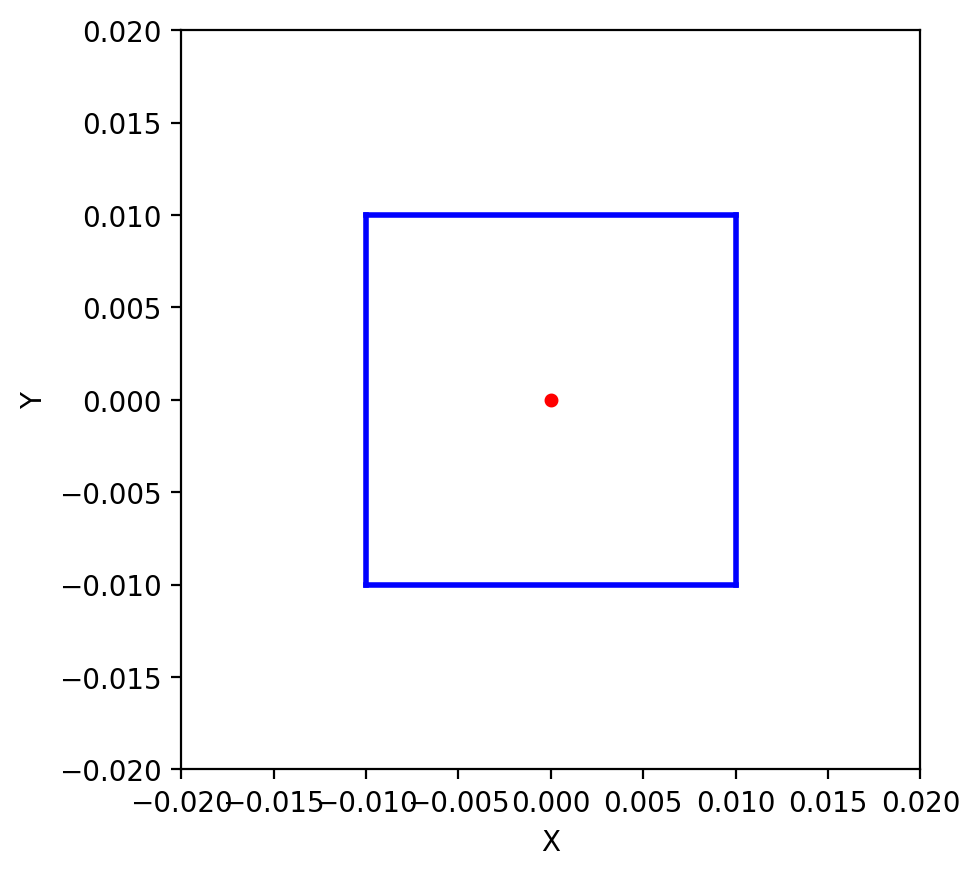

In [65]:
fig = plt.figure(dpi=200)
ax = plt.gca()

sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(0.04, 0.04, 0)),
    # eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000102043 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
     block, center = (0,0,0)
          size (1e+20,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
time for set_epsilon = 0.011096 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)
λ (μm)		net dipole power (W)
0.7000		9.754889e-03
0.6947		1.022959e-02
0.6896		1.071522e-02
0.6844		1.121366e-02
0.6794		1.172235e-02
0.6745		1.224263e-02
0.6696		1.277238e-02
0.6647		1.331217e-02
0.6600		1.386052e-02
0.6553		1.441711e-02
0.6507		1.498118e-02
0.6462		1.555145e-02
0.6417		1.612793e-02
0.6372		1.670837e-02
0.6329		1.729355e-02
0.6286		1.788034e-02
0.6243		1.847010e-02
0.6201		1.905908e-02
0.6160		1.964902e-02
0.6119		2.023577e-02
0.6079		2.082119e-02
0.6039		2.140104e-02
0.6000		2.197703e-02
0.5961		2.254516e-02
0.5923		2.310669e-02
0.5885		2.365814e-02

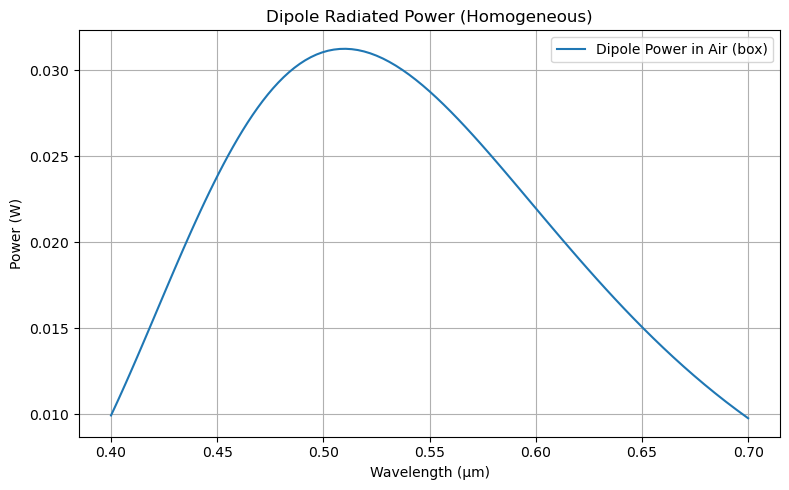

In [66]:
# === 시뮬레이션 실행 ===
sim.run(until=50)
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(), 1e-8))

# === 측정된 flux 데이터 얻기 ===
flux_freqs = mp.get_flux_freqs(box_power)   # 측정된 주파수 배열 (1/μm)
net_power = mp.get_fluxes(box_power)        # 측정된 각 주파수의 dipole 방사 power (W)

# === 파장으로 변환 (μm)
wavelengths = 1 / np.array(flux_freqs)

# === 결과 출력 예시
print("λ (μm)\t\tnet dipole power (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{net_power[i]:.6e}")

# === 시각화 (옵션)
plt.figure(figsize=(8,5))
plt.plot(wavelengths, net_power, label="Dipole Power in Air (box)", )
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power (Homogeneous)")
# plt.ylim([-3, 14])
# plt.xlim([0.1,1])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [67]:
import csv

# 저장할 파일 경로
filename = "dipole_power.csv"

# CSV로 저장
with open(filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Wavelength (μm)", "Power (W)"])  # 헤더
    for wl, power in zip(wavelengths, net_power):
        writer.writerow([wl, power])

print(f"CSV 파일 저장 완료: {filename}")

CSV 파일 저장 완료: dipole_power.csv
